**Author**: JSO  
**Date**: Aug 13  
**Description**:  
In this notebook, we use `unsloth` together with `datasets` to fine-tune LLMs ability to accurately detect data availability statements in papers. Don't ask where the data is coming from for now, i'll add details later on.

We use the following stack
 - libraries:
    - `unsloth`
    - `trl`
    - `datasets`
 - models:
    - `meta-llama/Llama-3-8B-Instruct` (huggingface)
 - hardware:
    - A100(40G)

The notebook has two parts:
1. Fine-tuning using unsloth
2. Quality assessment of our fine-tuned model

I would typically have the fine-tuning as its own python script, which I would submit to the VACC partition. For pedagogical purpose, we keep all the script within this notebook.

**Important: this notebook have conflicting dependencies with other notebooks. I encapsulated the dependencies using the `uv` package manager. To run the notebook, you need to use `uv` using the following command**:
```bash
uv sync --group fine_tuning
```

## Part I: Fine tuning using unsloth

In [ ]:
from unsloth import FastLanguageModel,  is_bfloat16_supported
from trl import SFTTrainer
from datasets import Dataset
from transformers import TrainingArguments
import pandas as pd
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
max_seq_length = 2048 # Supports automatic RoPE Scaling, so choose any number

# Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    max_seq_length=max_seq_length,
    dtype=None,  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit=False,  # Use 4bit quantization to reduce memory usage. Can be False
)

==((====))==  Unsloth 2025.8.5: Fast Llama patching. Transformers: 4.55.1.
   \\   /|    NVIDIA A100-PCIE-40GB. Num GPUs = 1. Max memory: 39.495 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# datas stuff
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Inputs:
{}

### Response:
{}"""


In [4]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples['text']
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [5]:
balanced_df = pd.read_csv("../data/train.csv")
balanced_df = balanced_df.rename(columns = {"Text": "text", "Label": "output"})
dataset = Dataset.from_pandas(balanced_df)

dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

In [6]:
# Do model patching and add fast LoRA weights
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.8.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [7]:
trainer = SFTTrainer(
    model=model,
    tokenizer = tokenizer,
    dataset_text_field = "text",
    train_dataset=dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 2,
        warmup_steps = 5,
        max_steps = 250,
        learning_rate = 5e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "./test_unsloth",
    )
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/106 [00:00<?, ? examples/s]

In [8]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

trainer_stats = trainer.train()

In [9]:
model.push_to_hub("jstonge1/dark-data-lora-balanced")
tokenizer.push_to_hub("jstonge1/dark-data-lora-balanced")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...petjp68q7/adapter_model.safetensors:   3%|2         | 8.39MB /  336MB            

Saved model to https://huggingface.co/jstonge1/dark-data-lora-balanced


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpkns11bog/tokenizer.json       : 100%|##########| 17.2MB / 17.2MB            

# Part 2: Quality assessment of our fine-tuned model
_restart the notebook_

In [ ]:
from unsloth import FastLanguageModel
from transformers import TextStreamer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from textwrap import wrap
import pandas as pd
import numpy as np


In [11]:
max_seq_length = 2048 
model_id = "jstonge1/dark-data-lora-balanced"
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_id, 
        max_seq_length = max_seq_length,
        dtype = None,
        load_in_4bit = False,
    )
FastLanguageModel.for_inference(model) 

==((====))==  Unsloth 2025.8.5: Fast Llama patching. Transformers: 4.55.1.
   \\   /|    NVIDIA A100-PCIE-40GB. Num GPUs = 1. Max memory: 39.495 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128255)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

In [12]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
stop_token_ids = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")]

In [13]:
# datas stuff
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Inputs:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples['text']
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }



In [14]:
df = pd.read_parquet("../data/annotated_data.parquet")
df = df[~df['sentiment'].str.contains('nan')]
df = df[df['sentiment'] != 'maybe']
df = df.drop_duplicates(subset='text')
df['sentiment_encoded'] = df.sentiment.map({'yes': 1, 'no': 0})
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_encoded'], test_size=0.2, random_state=42)

In [15]:
inputs = [tokenizer(
[
    alpaca_prompt.format(
       'Is data availability statement', # instruction
        text, # input
        "", 
    )
], return_tensors = "pt").to("cuda") for text in X_test]

In [16]:
replies = []
for i in inputs:
    outputs = model.generate(**i, max_new_tokens = 64, use_cache = True)
    reply = tokenizer.batch_decode(outputs)
    reply = reply[0].split("Response:\n")[-1].replace("<|eot_id|>", "")
    replies.append(reply)

In [50]:
y_pred = np.array(list(map(lambda x: int(x), replies)))

0.7796901893287436
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       551
           1       0.16      0.73      0.26        30
          37       0.00      0.00      0.00         0

    accuracy                           0.78       581
   macro avg       0.38      0.51      0.38       581
weighted avg       0.94      0.78      0.84       581



/users/j/s/jstonge1/llama_setup_vacc/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/users/j/s/jstonge1/llama_setup_vacc/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/users/j/s/jstonge1/llama_setup_vacc/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

<Figure size 800x600 with 0 Axes>

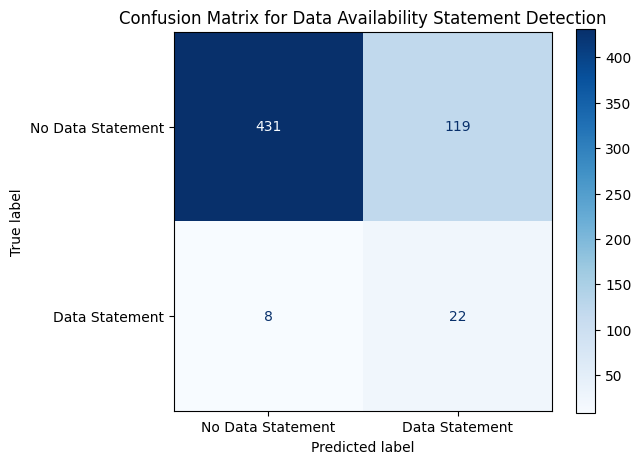

In [ ]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

mask = (y_test != 37) & (y_pred != 37)
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred[mask]

# Create and display the confusion matrix for binary classification
cm = confusion_matrix(y_test_filtered, y_pred_filtered, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Data Statement', 'Data Statement'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Data Availability Statement Detection')
plt.tight_layout()
plt.show()

Is it great? Not really. But it is better than all other approaches we tried so far. Lets just say there is room for improvement.

In [61]:
y_pred, y_test, X_test = np.array(y_pred), np.array(y_test), np.array(X_test)

In [62]:
# Predicted yes, but it is no
failed_pos_preds = np.array(X_test[np.where((y_pred == 1) & (y_pred != y_test))])
# Predicted no, but it is yes
failed_neg_preds = np.array(X_test[np.where((y_pred == 0) & (y_pred != y_test))])

In [21]:
# failed_pos_preds = np.array(X_te
print('\n'.join(wrap(failed_pos_preds[1])))

The **data** were analyzed using GraphPad PRISM, version 8.4.1,
GraphPad Software Inc. San Diego, CA, USA, statistical software. Data
were expressed as the mean ± standard error of the mean. The **data**
generated during the study were analyzed with one-way ANOVA followed
by Tukey's post hoc test for inter-group comparisons. P value ≤ 0.05
was considered statistically significant.


In [22]:
# Predicted no, but it is yes
print('\n'.join(wrap(failed_neg_preds[1])))

Procedures for conducting a convincing sensitivity analysis may depend
strongly on the specific model and data , and such procedures are
still being developed [ 89][90][91][92][93 ] . The choice of other
priors to compare is crucial , yet can be controversial . In
applications for which the duration of each individual MCMC is long ,
an exhaustive sensitivity analysis may take a very long time , and
efficiencies may need to be introduced . Therefore the guidelines here
are general , and the analyst is encouraged to explore the literature
for model - specific recommendations . Ultimately , the analyst must
be thoughtful in exploring plausibly interesting variations in the
prior and be forthright in presenting the results . Because of the
potential length of a thorough presentation , online supplementary
material may be needed and is encouraged ( see ' Make it reproducible
' ( BARG step 6 ) ) . Reporting points are listed in Table 1 .


## Previous models

_llama-3-8B-instruct_ (current)
```
0.7796901893287436
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       551
           1       0.16      0.73      0.26        30
          37       0.00      0.00      0.00         0

    accuracy                           0.78       581
   macro avg       0.38      0.51      0.38       581
weighted avg       0.94      0.78      0.84       581
```

_llama-3-8B-instruct_ (undertrained)
```
0.729776247848537
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       551
           1       0.11      0.57      0.18        30

    accuracy                           0.73       581
   macro avg       0.54      0.65      0.51       581
weighted avg       0.92      0.73      0.80       581
```

_llama-3.2-3B-instruct_
```
0.5215146299483648
              precision    recall  f1-score   support

           0       0.99      0.50      0.67       551
           1       0.09      0.90      0.16        30

    accuracy                           0.52       581
   macro avg       0.54      0.70      0.41       581
weighted avg       0.94      0.52      0.64       581
```

_llama-3.1-8B-instruct_ was terrible, im not even showing it.